## Барсегян Давид. DS в разведке и добыче нефти / GPN CUP 2024

Данные описывают множество различных походов с целью поиска артефактов. Мы надеемся разработать модель машинного обучения, которая сможет найти зависимость между признаками, которыми мы располагаем, и общим временем поиска. Знание времени, необходимого для похода, позволит оптимизировать весь процесс и приведет к урежению дополнительных затрат. Для начала импортируем необходимые библиотеки и загрузим наш датасет  

In [1]:
#импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import re
import missingno as msno
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
from collections import Counter
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
#загружаем данные
data = pd.read_csv('/Users/davidbarsegyan/Downloads/Data scientist в разведке и добыче нефти/data.csv', header=0)
data.head()

,Наименование королевства,Наименование земли,Наименование хребта,Наименование расщелины,Цель,Тип расщелины,Категория расщелины,Назначение расщелины,Участки,Тип отвилка,...,Количество простоев по зельям,Количество простоев в контроле поиска,Количество простоев в конце расщелины,Количество простоев по долбилам,Количество простоев по вине исследователей,Количество простоев по креплениям,Количество простоев (прочие),Общий путь поиска,Дата начала поиска,Дата окончания поиска
0,Кэдвен,Приобия,684,2903,поиск,наклонная,Нагнетательная,Магическое воздействие,верхнее укрепление+среднее укрепление+основное...,Материнский,...,2.7,0.0,0.0,0.0,0.0,0.0,0.0,2889.0,2162-12-23 15:00:17,2163-01-04 07:00:17
1,Темерия,Сутор,1141,1332,поиск,горизонтальная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5620.5,2162-11-09 00:00:17,2163-01-05 04:30:17
2,Кэдвен,Приобия,18А.28,1027,поиск,наклонная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,...,0.0,0.0,0.0,0.0,0.0,0.9,0.0,2600.1,2162-12-24 23:30:17,2163-01-06 02:30:17
3,Кэдвен,Приобия,9А.18,4208,поиск,наклонная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2699.1,2162-12-24 12:00:17,2163-01-06 01:00:17
4,Кэдвен,Приобия,627,9352,поиск,наклонная,Нагнетательная,Магическое воздействие,верхнее укрепление+среднее укрепление+основное...,Материнский,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3195.0,2162-12-24 12:00:17,2163-01-07 19:00:17


Как видим, походы описаны по 53 признакам. Из них 23 являются категориальными, а 27 - количественными. Также надо выделить признаки "Общее время поиска", "Дата начала поиска", "Дата окончания поиска" - это наши целевые переменные

In [3]:
#Заменям пробелы на Nan чтобы верно отобразить все пропуски
data = data.replace(r'^\s+$', np.nan, regex=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13416 entries, 0 to 13415
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Наименование королевства                    13416 non-null  object 
 1   Наименование земли                          13416 non-null  object 
 2   Наименование хребта                         13416 non-null  object 
 3   Наименование расщелины                      13416 non-null  int64  
 4   Цель                                        13416 non-null  object 
 5   Тип расщелины                               13414 non-null  object 
 6   Категория расщелины                         13416 non-null  object 
 7   Назначение расщелины                        10800 non-null  object 
 8   Участки                                     11680 non-null  object 
 9   Тип отвилка                                 13208 non-null  object 
 10  Технологич

<Axes: >

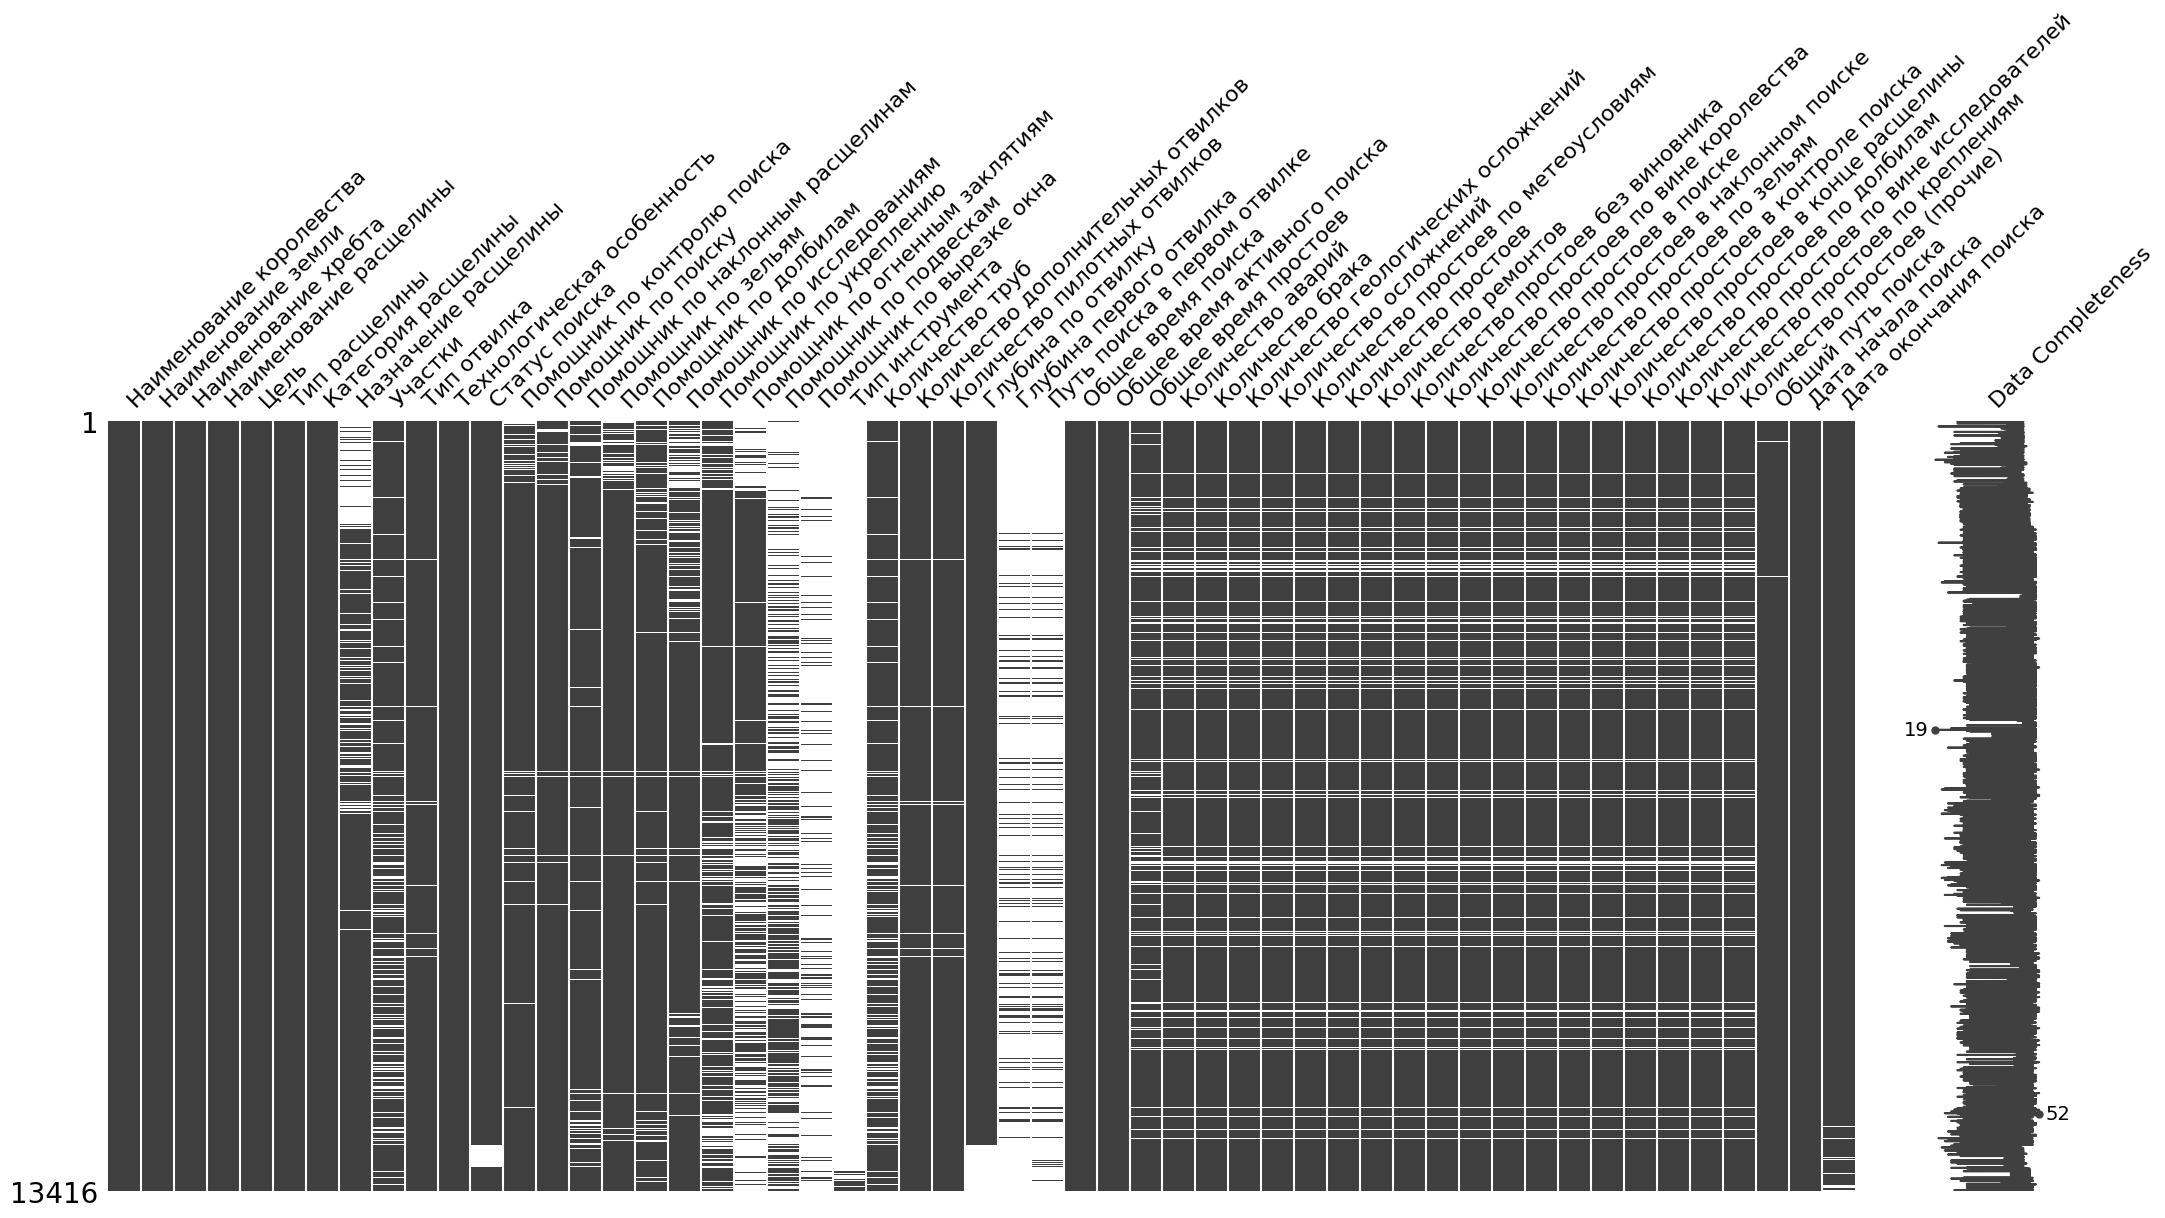

In [4]:
msno.matrix(data, labels=True)

## Посмотрев внимательно на данные, мы можем сделать предварительные выводы:
1. Такие признаки, как "Количество аварий", "Количество простоев" и т.д. обладают большой ценностью, но мы не можем использовать их напрямую, так как эти признаки определяются уже после окончания похода. Мы же хотим построить модель, которая будет заранее предсказывать время
2. Такие признаки как "Наименование хребта", "Наименование расщелины" обладают двумя свойствами. Во-первых они характеризуются высокой кардинальностью, то есть высокой уникальностью данных. Это значит, что такие простые методы обработки классов, как One-hot encoding, обрекут нас на проклятие размерности. Во-вторых, мы можем планировать добычу артефактов в новых расщелинах и новых хребтах, которых не было в обучающей выборке - это unseen features
3. Во многих признаках есть пропуски, необходимо их обработать. Также надо оценить наличие выбросов и определить ключевые признаки

Это все станет частью развыдевательного анализа данных. Мы должны привести данные к целевому виду

# 1. Рассмотрим признаки и выделим ключевые

## 1. Место похода
Четыре признака описывают местонахождение работ. Это "Наименование королевства", "Наименование земли", "Наименование хребта", "Наименование расщелины". Интуитивно понятно, что эти показатели имеют большое влияние: в разных районах будут разные метеорологические и геологические условия, что будет напрямую влиять на длительность работ. Наверняка королевства будут отличаться по достатку и доступным ресурсам, поэтому выбор помощников также будет разниться. Вполне возможно, что от местности будут зависеть технологические особенности. Для начала взглянем на признак "Наименование королевства":

                          Общее время поиска
Наименование королевства                    
Аэдирн                                18.120
Бругге                                23.520
Верден                                26.960
Зеррикания                            16.100
Каэд Ду                               17.880
Кэдвен                                23.270
Лирия и Ривия                         20.470
Редания                               30.220
Скеллиге                              46.305
Темерия                               26.080


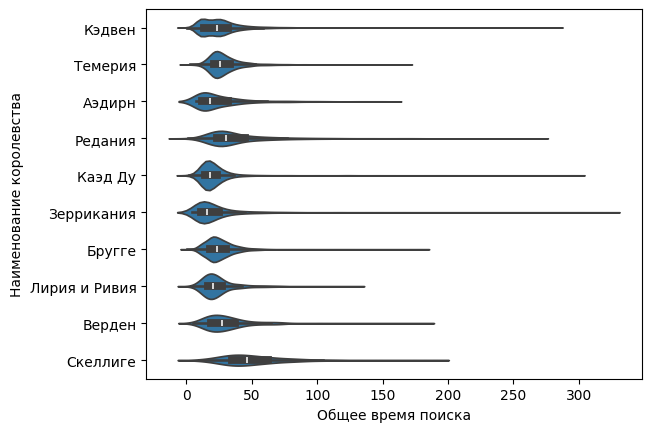

In [5]:
sns.violinplot(data=data, y='Наименование королевства', x='Общее время поиска')
print(data[['Наименование королевства', 'Общее время поиска', ]].groupby('Наименование королевства').median())

Как и ожидалось, медиана общего времени поиска варьируется: от 16-17 дней в Зеррикании и Каэд Ду до 46 и 30 дней в Скеллиге и Редании соответственно. Этот признак определенно ценен для нас. Можно попытаться найти объяснение данным цифрам: посмотрим распределение осложнений и простоев в королевствах

<Axes: xlabel='Количество геологических осложнений', ylabel='Наименование королевства'>

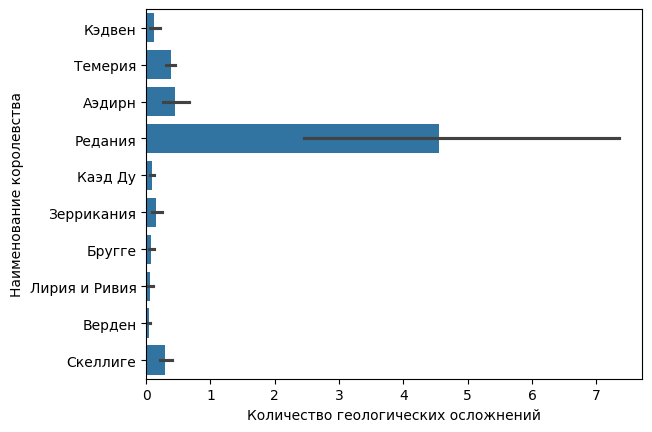

In [6]:
data[['Наименование королевства', 'Количество геологических осложнений', 'Количество простоев по метеоусловиям', 'Общее время простоев', 'Общее время поиска', 'Количество простоев в конце расщелины', 'Количество аварий', 'Количество брака', 'Количество простоев в поиске', 'Количество простоев по вине исследователей']].groupby('Наименование королевства').mean('Количество геологических осложнений', 'Количество простоев по метеоусловиям')
sns.barplot(data=data, y='Наименование королевства', x='Количество геологических осложнений')

Как видим, в Редании наблюдается огромное количество геологических осложнений. Это закономерно отразилось на общем времени поиска - 30 дней. А что насчет королевства Скеллиге с 46 днями?

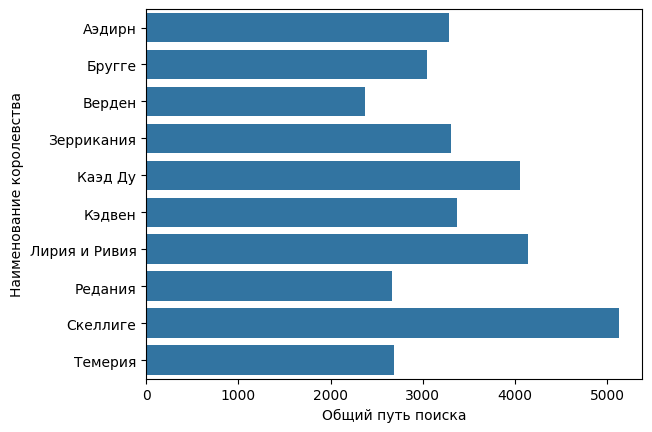

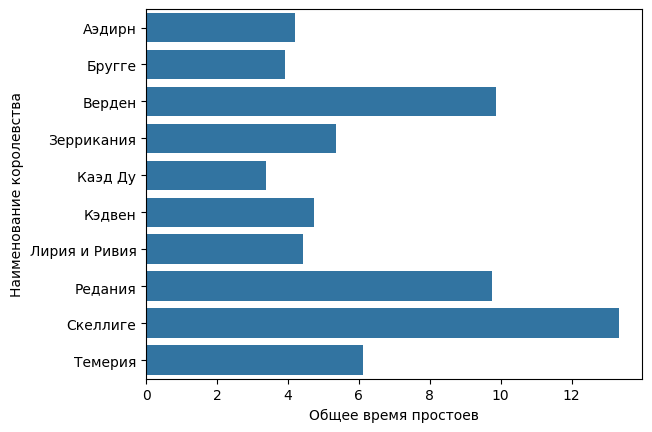

In [7]:
data_1 = data[['Наименование королевства', 'Общее время простоев', 'Общий путь поиска']].groupby('Наименование королевства').mean()

sns.barplot(data=data_1, x="Общий путь поиска", y="Наименование королевства") 
plt.show()
sns.barplot(data=data_1, x="Общее время простоев", y="Наименование королевства") 
plt.show()


В королевстве Скеллиге героям приходилось преодолевать наибольший путь. Также с походами в Скеллиге были связаны наибольшие простои. Видимо слишком длинный путь накладывает сложности на добычу артефактов и вынуждает делать много пауз

От королевства зависит многое, это важный и ценный признак. Так как королевств немного, мы можем закодировать их с помощью one-hot encoding.

Помимо королевств, мы распологаем информацией о наименовании хребта, земли и расщелины. Из тех же соображений мы должны использовать эти данные в модели

In [8]:
print(f'В обучающей выборке {len(data['Наименование земли'].value_counts())} уникальных земель, {len(data['Наименование хребта'].value_counts())} хребтов и {len(data['Наименование расщелины'].value_counts())} расщелин') 

В обучающей выборке 149 уникальных земель, 703 хребтов и 4947 расщелин


Мы закодируем их с помощью mean encoding. Если появяться новые расщелины, которых не было в нашем датасете, то мы закодируем среднее по королевству - будет считать, что все королевства в этом мире уже известны и занесены в выборку и что этот мир политически стабилен

### Есть еще одно важное замечание - в хребтах названия неоднородны, то есть в некоторых присутствуют буквы. Можем посмотреть, характеризует ли это как-то хребты

In [9]:
def count_letters(series):
    # Объединяем все строки в одну
    all_text = ''.join(series)

    # Фильтруем только буквы
    letters_only = ''.join(char for char in all_text if char.isalpha())

    # Используем Counter для подсчета букв
    letter_count = Counter(letters_only)

    return dict(letter_count)

letters_dict = count_letters(data['Наименование хребта'])
letters_dict

{'А': 398,
 'П': 86,
 'Б': 42,
 'Я': 1,
 'Ш': 6,
 'М': 71,
 'Н': 130,
 'К': 377,
 'Г': 235,
 'З': 1,
 'Р': 62,
 'Т': 11,
 'Д': 108,
 'И': 47,
 'б': 1,
 'и': 5,
 'с': 5,
 'n': 20,
 'a': 10,
 'С': 188,
 'M': 2,
 'Л': 9}

In [10]:
for key in ['А','К','Н']:
    data['В названии хребта есть буква ' + key] = data['Наименование хребта'].apply(lambda word: 1 if key in word else 0)

In [11]:
#Проверим как меняется время похода у самых "популярных" букв

for key in ['А','К','Н']:
    
    print('Статистика для буквы: ' + key)
    print(data.groupby('В названии хребта есть буква ' + key).describe()['Общее время поиска']['mean'])
    print('-----------------')

#Для буквы К не была замечена  разница. Оставим только наличие буквы А и Н
data = data.drop(columns = 'В названии хребта есть буква К')

Статистика для буквы: А
В названии хребта есть буква А
0    27.88272
1    32.08706
Name: mean, dtype: float64
-----------------
Статистика для буквы: К
В названии хребта есть буква К
0    28.000302
1    28.256074
Name: mean, dtype: float64
-----------------
Статистика для буквы: Н
В названии хребта есть буква Н
0    27.985766
1    30.227077
Name: mean, dtype: float64
-----------------


Есть разница для букв "A" и "H". Мы сохранили эту информацию, сделав бинарные признаки по наличию этих букв в наименовании хребтов(1 - есть, 0 - нет)

## 2. Признаки, описывающие технические особенности расщелины и похода

Тип расщелины, Категория расщелины, Назначение расщелины, Участки, Тип отвилка, Технологическая особенность, Статус поиска. Какие тут есть важные признаки? Большое влияние будет иметь цель - логично, что разведка часто затягивается и требует больше времени, чем рутинный поиск и зарезка бокового отвилка. Это наглядно видно на графике:

<Axes: xlabel='Общее время поиска', ylabel='Цель'>

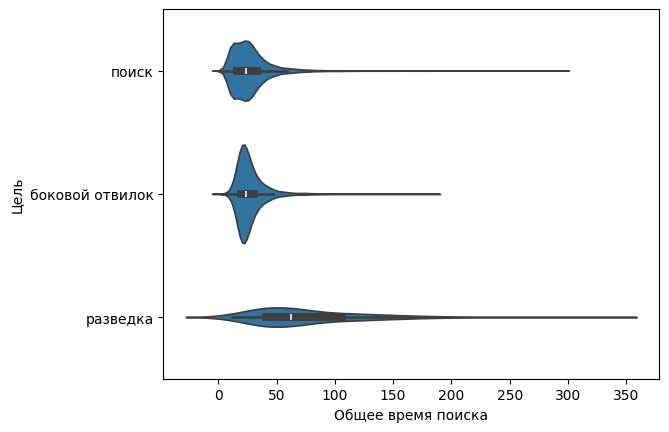

In [12]:
sns.violinplot(data=data, y='Цель', x='Общее время поиска')

Тип расщелины также оказался важным признаком. Разница во времени поиска оказалась значительной - от 14 дней в наклонных расщелинах до 50 в вертикальных

                Общее время поиска
Тип расщелины                     
вертикальная                 49.97
горизонтальная               26.06
многощельная                 26.95
наклонная                    14.36


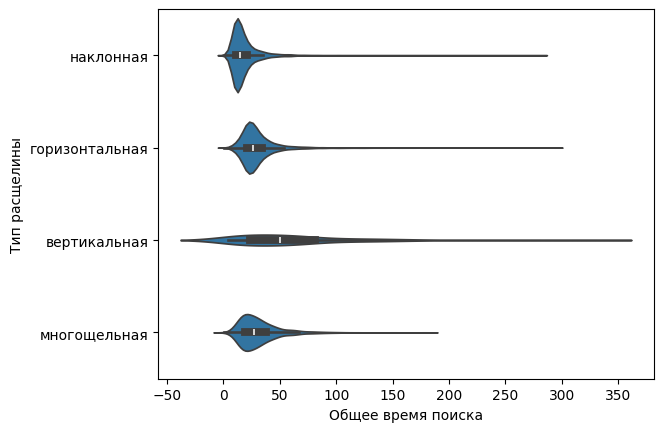

In [13]:
sns.violinplot(data=data, y='Тип расщелины', x='Общее время поиска')
print(data[['Тип расщелины', 'Общее время поиска']].groupby('Тип расщелины').median())

Аналогично остальные признаки также важны в определении общего времени поиска. Категория расщелины определяет ее общую структуру, Назначение расщелины характеризует походы по сложности добычи разных артефактов, Участки определяют секции расщелины, Тип отвилка определяет путь, который мы будем эксплуатировать, Технологическая особенность расширяет информацию, полученную из знаний типа расщелин. 



In [14]:
#Признак "Статус поиска" не так важен для обучения. Единственное, что мы можем сделать с ним - удалить информацию о незавершенных походах
data["Статус поиска"].value_counts()

Статус поиска
завершен      12868
в процессе      165
Name: count, dtype: int64

Признак "Статус поиска" указывает нам, что 165 походов еще в процессе - значит мы не можем их использовать. Нам придется убрать информацию об этих походах

In [15]:
rows_count = len(data)
data = data.drop(data[data["Статус поиска"] == 'в процессе'].index)

print(f"Теперь в наших данных информация о {rows_count - 165} походах")

Теперь в наших данных информация о 13251 походах


## 3. Помощники и тип инструмента

Это категориальные признаки с высокой кардинальностью. Тип инструмента мы даже рассматривать не будем - этот признак мог бы быть важен, но количество пропусков слишком велико - 97%! Помощников мы закодируем по принципу mean encoding по тем признакам, которые должны напрямую зависеть от них:
Помощник по исследованиям - закодируем по "Количество простоев по вине исследователей"
Помощник по зельям - закодируем по "Количество простоев по зельям"
и т.д.

Если нет прямого показателя их работы, мы можем кодировать по целевой переменной

In [16]:
#создадим словарь для сопоставления помощника и признака-показателя качества
helper_dict = {
    'Помощник по исследованиям' : "Количество простоев по вине исследователей",
    'Помощник по зельям' : "Количество простоев по зельям",
    'Помощник по контролю поиска' : "Количество простоев в поиске",
    'Помощник по поиску' : "Количество простоев в поиске",
    'Помощник по наклонным расщелинам' : "Количество простоев в наклонном поиске",
    'Помощник по долбилам' : "Количество простоев по долбилам",
    'Помощник по укреплению' : "Количество простоев по креплениям",
    'Помощник по огненным заклятиям' : "Количество простоев (прочие)",
    'Помощник по подвескам' : None,
    'Помощник по вырезке окна' : None
}

#признак "Помощник по вырезке окна" обладает слишком большим количеством пропусков. 
#Оставшийся признак  - Помощник по подвескам, у него также высокое количество  пропусков, ему нет прямых
#показателей качества и связывать их с целевой переменной не кажется хорошей идеей

In [17]:
#Посмотрим на количества простоев по зельям среди 10 самых популярных помощников по зельям
list_of_values = data["Помощник по зельям"].value_counts()[:10].index.tolist()
print(list_of_values)
exp_data = data[data["Помощник по зельям"].isin(list_of_values)]

print(exp_data[["Помощник по зельям", "Количество простоев по зельям"]].groupby(["Помощник по зельям"]).mean())

['Альянс Хранителей Рун', 'Гильдия Инженеров Петро', 'Туманные Кузнецы Ши', 'Альянс Мудрецов и Травников Нильфгаарда', 'Специальная Служба Петра (ООО СПС)', 'Краснолюдский Цех Буровых Технологий', 'Филиал Мастеров Халл', 'Нордский Союз Конструкторов', 'Гильдия Сервисных РаботТЭК-Бурение', 'Гильдия Долговременного Бурения']
                                         Количество простоев по зельям
Помощник по зельям                                                    
Альянс Мудрецов и Травников Нильфгаарда                       0.442829
Альянс Хранителей Рун                                         0.362141
Гильдия Долговременного Бурения                               0.110204
Гильдия Инженеров Петро                                       0.579576
Гильдия Сервисных РаботТЭК-Бурение                            0.458621
Краснолюдский Цех Буровых Технологий                          0.385714
Нордский Союз Конструкторов                                   1.055455
Специальная Служба Петра (ООО СПС)  

<Axes: xlabel='Количество простоев по зельям', ylabel='Общее время поиска'>

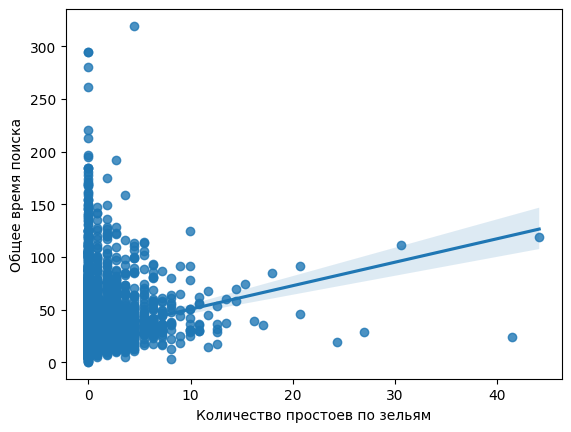

In [18]:
#Ожидаемо, у разных помощников разное количество простоев по зельям. Но влияют ли количества простоев по зельям на общее время поиска?
sns.regplot(data=data, x="Количество простоев по зельям", y="Общее время поиска")
#Как видим, присутствует слабая зависимость. Малая корреляция объясняется тем, что этот признак далеко не первостепенен в определении времени
#похода

## 4. Ценнные признаки, которые мы не можем использовать при использовании модели

Огромное количество признаков.
Количество труб, Количество дополнительных отвилков, Количество пилотных отвилков, Глубина по отвилку, Глубина первого отвилка, 
Путь поиска в первом отвилке, Общее время активного поиска, Общее время простоев, 
Количество аварий, браков и осложнений по всевозможным причинам, Общий путь поиска...

Все эти признаки тяжело и даже невозможно заранее учесть, чтобы потом использовать в нашей модели. Но мы можем попробовать на их основе заняться feature engineering. Допустим признак "Количество простоев по вине королевства". Мы можем сделать новый признак - коэффициент простоев для королевств. И присвоить каждому королевству значение согласно среднему количеству простоев по вине королевства в походах на территории этого королевства - как mean encoding, но не по целевой переменной. Аналогично поступим с остальными признаками. 

In [19]:
features = ['Количество труб', 'Количество дополнительных отвилков', 'Количество пилотных отвилков', 'Глубина по отвилку', 'Глубина первого отвилка', 
'Путь поиска в первом отвилке',  'Общее время простоев', 'Количество аварий', 'Количество брака', 'Количество геологических осложнений', 
 'Количество осложнений', 'Количество простоев по метеоусловиям', 'Количество простоев', 'Количество ремонтов', 'Количество простоев без виновника',
 'Количество простоев по вине королевства' , 'Количество простоев в поиске', 'Количество простоев в наклонном поиске', 'Количество простоев по зельям',
  'Количество простоев в контроле поиска', 'Количество простоев в конце расщелины', 'Количество простоев по долбилам',
 'Количество простоев по вине исследователей', 'Количество простоев по креплениям', 'Количество простоев (прочие)', 'Общий путь поиска']
print(f'К таким признакам относятся {features}. \n\nВсего нам придется удалить {len(features)} признаков, но перед этим мы постараемся закодировать информацию, которую они хранят')


К таким признакам относятся ['Количество труб', 'Количество дополнительных отвилков', 'Количество пилотных отвилков', 'Глубина по отвилку', 'Глубина первого отвилка', 'Путь поиска в первом отвилке', 'Общее время простоев', 'Количество аварий', 'Количество брака', 'Количество геологических осложнений', 'Количество осложнений', 'Количество простоев по метеоусловиям', 'Количество простоев', 'Количество ремонтов', 'Количество простоев без виновника', 'Количество простоев по вине королевства', 'Количество простоев в поиске', 'Количество простоев в наклонном поиске', 'Количество простоев по зельям', 'Количество простоев в контроле поиска', 'Количество простоев в конце расщелины', 'Количество простоев по долбилам', 'Количество простоев по вине исследователей', 'Количество простоев по креплениям', 'Количество простоев (прочие)', 'Общий путь поиска']. 

Всего нам придется удалить 26 признаков, но перед этим мы постараемся закодировать информацию, которую они хранят


## 5. Дата начала и окончания похода

Предположение - в зависимости от времени года по разным обстоятельствам время похода будет отличаться. Давайте проверим эту гипотезу

In [20]:
def date_to_month(datestring):
       dt = datetime.strptime(datestring, '%Y-%m-%d %H:%M:%S')
       month_number = dt.month
       months = [
              "Январь", "Февраль", "Март", "Апрель",
              "Май", "Июнь", "Июль", "Август",
              "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"
       ]

       if 1 <= month_number <= 12:
              return months[month_number - 1]  # Месяцы начинаются с 0
       else:
              return "Некорректный номер месяца"

In [21]:
data['Месяц начала работ'] = data['Дата начала поиска'].apply(lambda x: date_to_month(x))

In [22]:
data[['Месяц начала работ', 'Общее время поиска']] .groupby('Месяц начала работ').mean()['Общее время поиска']

Месяц начала работ
Август      25.705908
Апрель      27.438520
Декабрь     31.572294
Июль        25.886185
Июнь        26.932845
Май         26.579020
Март        27.998462
Ноябрь      30.644161
Октябрь     28.408996
Сентябрь    26.724004
Февраль     29.537303
Январь      30.031070
Name: Общее время поиска, dtype: float64

Как и ожидалось, время года влияет на длительность похода: минимум наблюдается летом, затем идет рост осенью и пик в декабре, а затем спад до лета. Мы можем на основе даты начала похода сделать новый признак - месяц начал, и затем сделать one-hot по 12 категориям. После этого можно удалить признаки начала и окончания похода

# 2. Обработка пропущенный значений, кодирование категорий и исключение признаков

Для начала давайте определим функции для кодирования категориальных признаков. Пропуски в количественных признакак заполним с помощью множественной импутации, а пропуски в категориальных с помощью KNNimputer


### One-HOT encoding

In [23]:
def one_hot_encode(df, column, need_delete_column):
    if column not in df.columns:
        raise ValueError(f"Столбец '{column}' не найден в DataFrame.")

    one_hot = pd.get_dummies(df[column], prefix=column, drop_first=True)

    df = pd.concat([df, one_hot], axis=1)
    if need_delete_column:
        df.drop(column, axis=1, inplace=True)

    return df

### Mean-encoding

In [24]:
def mean_encoding_by_column(df, column, target_column, name_for_column: str, need_delete_column):
    cat_dict = data.groupby(column).describe()[target_column]['mean']
    df[name_for_column] = df[column].apply(lambda x: cat_dict[x] if x in cat_dict else np.nan)
    if need_delete_column:
        df = df.drop(column, axis=1)
    return df

### Давайте посмотрим на долю пропущенных значений по каждому признаку:

In [25]:
print(data.isna().mean()*100+data.isin([' ']).mean()*100)
#По каждому признаку процент NaN значений плюс процент пробелов

Наименование королевства                       0.000000
Наименование земли                             0.000000
Наименование хребта                            0.000000
Наименование расщелины                         0.000000
Цель                                           0.000000
Тип расщелины                                  0.015093
Категория расщелины                            0.000000
Назначение расщелины                          19.741906
Участки                                       12.882047
Тип отвилка                                    1.569693
Технологическая особенность                    0.015093
Статус поиска                                  2.890348
Помощник по контролю поиска                    5.056222
Помощник по поиску                             2.520564
Помощник по наклонным расщелинам               4.452494
Помощник по зельям                             4.316655
Помощник по долбилам                           5.033582
Помощник по исследованиям                     10

### Немало признаков обладают пропущенными значениями. Особенно выделяются признаки "Помощник по вырезке окна", "Тип инструмента", "Глубина первого отвилка", "Путь поиска в первом отвилке". В них 88%+ пропусков, поэтому нам придеться избавиться от них

In [26]:
print(f'После удаления признаков с большим количеством пропусков из {len(data.columns)} признаков осталось', end=' ')
data = data.drop(columns=["Помощник по вырезке окна", "Тип инструмента", "Глубина первого отвилка", "Путь поиска в первом отвилке","Помощник по подвескам"])
print(len(data.columns))


features.remove('Глубина первого отвилка')
features.remove('Путь поиска в первом отвилке')


После удаления признаков с большим количеством пропусков из 56 признаков осталось 51


### С помощью модуля fancyimpute обработаем пропуски в количественных признаках

In [27]:
MICE_imputer = IterativeImputer()
wv7_rusHappy_mice = data[features].copy(deep=True)
wv7_rusHappy_mice.iloc[:, :] = MICE_imputer.fit_transform(wv7_rusHappy_mice)

data[features] = wv7_rusHappy_mice

<Axes: >

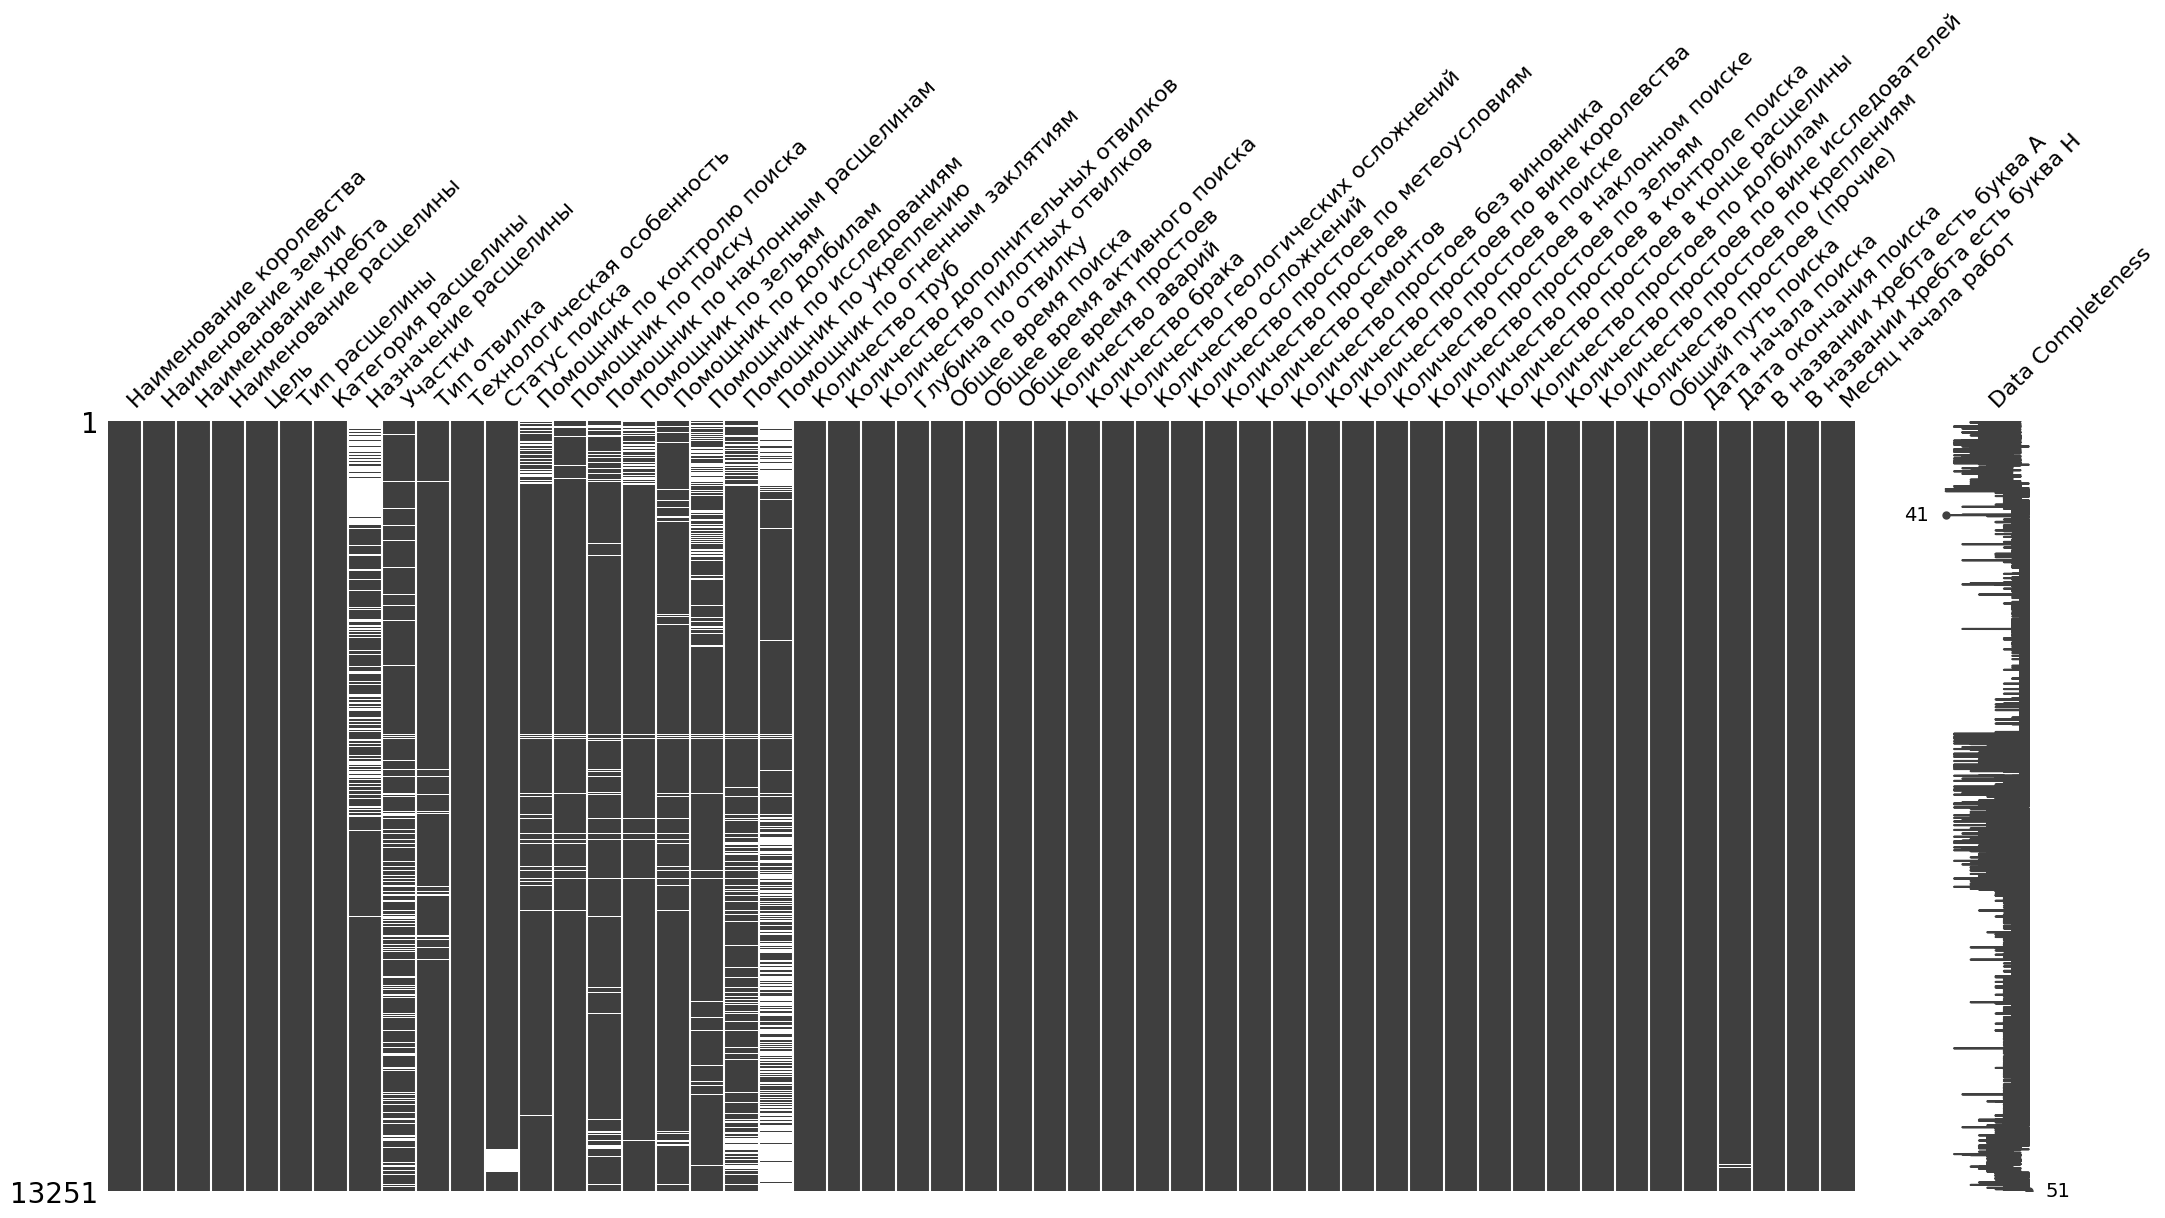

In [28]:
msno.matrix(data, labels=True)
#Как видим, импутация удалась, последние ~20 признаков без пропусков

### Теперь обратимся к категориальным признакам. В них не так много пропусков, мы можем воспользоваться функцией mean_encoding_by_column и затем ззаполнить пропуски с помощью KNNimputing

In [29]:
#для mean-encoding. Дальше мы закодируем признаки с малой кардинальностью по принципу one-hot
categorical_features = ["Наименование земли", "Наименование хребта", "Наименование расщелины", "Категория расщелины",
"Назначение расщелины", "Участки", "Тип отвилка", "Технологическая особенность", "Статус поиска", "Помощник по контролю поиска", "Помощник по поиску",
"Помощник по наклонным расщелинам", "Помощник по зельям", "Помощник по долбилам", "Помощник по исследованиям", "Помощник по укреплению","Помощник по огненным заклятиям"]

for feature in categorical_features:
    target_col = "Общее время поиска"
    if feature in list(helper_dict.values()):
        target_col = helper_dict[feature]
        #Для признаков-помощников мы выделяем фичи по которым закодируем их. С этим нам поможем объявленный раннее словарь helper_dict
    if feature == "Наименование земли":
        #Наименование земли нам еще будет нужно - поэтому этот признак дропать при кодировании не будем
        data = mean_encoding_by_column(data, feature, target_col, feature+'[encoded]', False)
        continue
    data = mean_encoding_by_column(data, feature, target_col, feature+'[encoded]', True)


In [30]:
#Мы уже использовали данные о времени начала и окончания поиска, поэтому их можно дропать
data = data.drop(columns=["Дата начала поиска", "Дата окончания поиска"], axis=1)


### Категориальные признаки с низкой кардинальностью мы закодируем ниже с помощью one-hot encoding

In [31]:
cat_one_hot=["Наименование королевства", "Цель", "Тип расщелины", "Месяц начала работ"]

for feat in cat_one_hot:
    if feat == "Наименование королевства":
        data = one_hot_encode(data, feat, False)
        continue
    data = one_hot_encode(data, feat, True)



### Прежде чем дропнуть все количественные признаки, закодируем их по принципу mean-encode по наименованиям земель

Признак земли был выбран по принципу компромисса между выбором закодировать по наименованиям королевств или по наименованиям расщелин

In [32]:
for feature in features:
    target_col = feature
    data = mean_encoding_by_column(data, "Наименование земли", target_col, feature+'[encoded]', False)

### Осталось удалить признаки, которые мы уже закодировали и использовали как могли

In [34]:
data=data.drop(columns=["Наименование королевства", "Наименование земли", "Общее время активного поиска"], axis=1)

In [35]:
#Избавляемся от количественных признаков из изначального датасета
data=data.drop(columns=features, axis=1)

### И последнее - заполним пропуски у некоторых некогда категориальных признаков

In [36]:
knn_imputer=KNNImputer(n_neighbors=5)
data_matrix = knn_imputer.fit_transform(data)

In [37]:
data = pd.DataFrame(data_matrix, columns=data.columns)
print(data.isna().mean()*100+data.isin([' ']).mean()*100)
#Как видим, все пропуски обработаны и все планировавшиеся признаки созданы

Общее время поиска                                     0.0
В названии хребта есть буква А                         0.0
В названии хребта есть буква Н                         0.0
Наименование земли[encoded]                            0.0
Наименование хребта[encoded]                           0.0
                                                      ... 
Количество простоев по долбилам[encoded]               0.0
Количество простоев по вине исследователей[encoded]    0.0
Количество простоев по креплениям[encoded]             0.0
Количество простоев (прочие)[encoded]                  0.0
Общий путь поиска[encoded]                             0.0
Length: 69, dtype: float64


# Обучение с помощью CatBoostRegressor

In [38]:
# X - наша обучающая выборка, Y - целевая переменная
X = data.drop(columns=['Общее время поиска'], axis=1)
Y = data['Общее время поиска']

In [39]:
#Для валидации отложим 25 процентов выборки
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=7)

### Мы используем метод градиентного бустинга. Это ансамблевый метод построенный по принципу бустинга - последовательного обучения малых моделей. Каждая последующая модель учиться на антиградиент функции потерь всего предыдущего ансамбля. Учитывая сложную природу наших данных, разумно использовать этот метод, ведь градиентный бустинг эффективно находит нелинейные зависимости

In [44]:
model = CatBoostRegressor(iterations = 5000, learning_rate = 0.05, random_seed=42, verbose=0)
model.fit(x_train, y_train)

In [45]:
model.predict(x_test)

array([23.11933294, 23.65065798, 37.15648812, ..., 14.13674779,
       15.54659758, 77.71568214])

In [46]:
print('MSE: ', mean_squared_error(model.predict(x_test), y_test))
print('MAE: ', mean_absolute_error(model.predict(x_test), y_test))

MSE:  106.96555340232804
MAE:  6.064949518860498


### Среднеквадратичная ошибка составила - 106, а абсолютная - 6

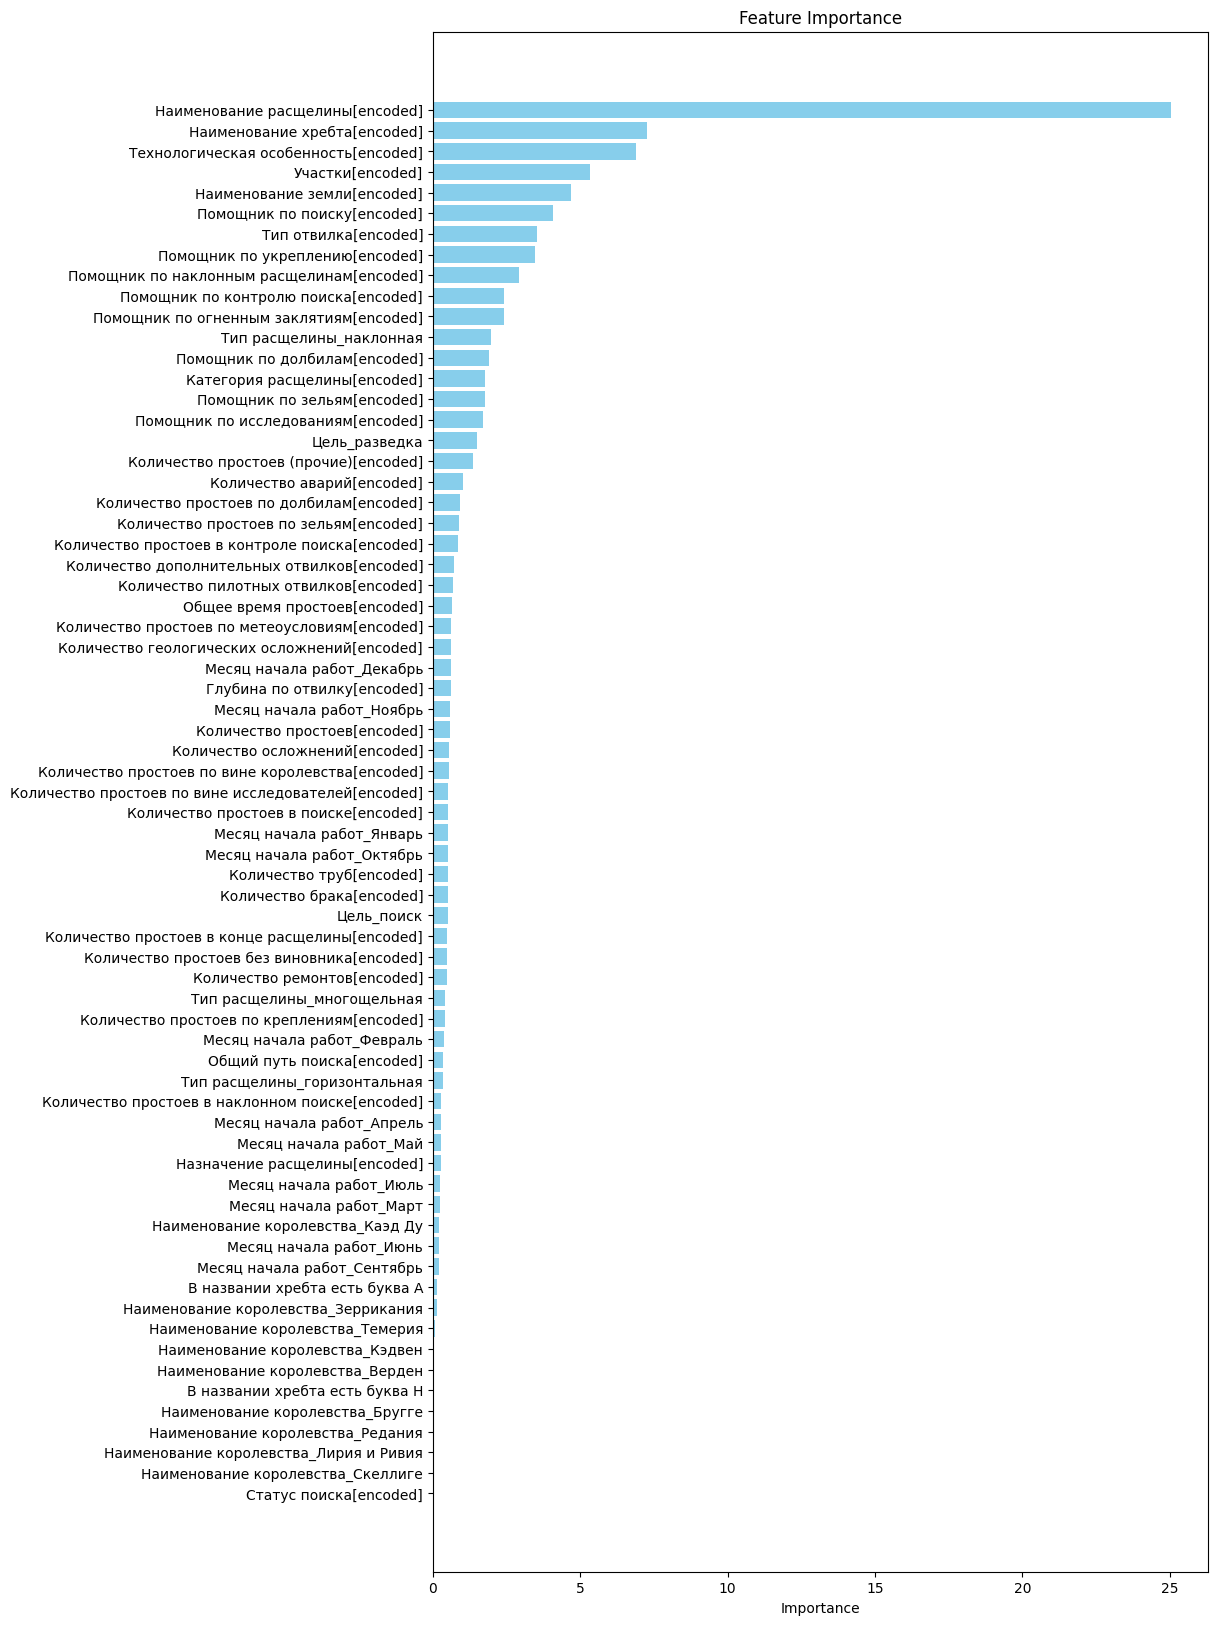

In [47]:
#Получить важность признаков
feature_importance = model.get_feature_importance()
feature_names = X.columns

#Создать DataFrame 
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

#Сортировка по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Инвертируем ось Y для лучшего отображения
plt.show()

### Напоследок мы посмотрели feature importance. Ожидаемо ключевыми оказались технические признаки(Технологическая особенность, Участки) и признаки расположения похода(Наименование хребта, расщелины, земли)

Для этой модели не хватает пайплайн для обработки входных данных, но непонятен формат данных, который будет использоваться на этой моделе